In [1]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline 

In [2]:
# to see all the columns when using head() or describe()
pd.set_option('display.max_columns',60)

In [27]:
# df = pd.read_csv("kenya_data/diaries_transactions_all.csv", dtype={'account_startclose_balance': str})

In [3]:
df = pd.read_csv("../diaries_transactions_all.csv", dtype={'account_startclose_balance': str})

## For now I keep only "business and agriculture loans", "joint liability loans", "personal loans", "borrowing from an informal group", "borrowing from family and friends", "shylock loans".

In [4]:
dfb = df[((df["trx_family_code"]=="FRMLN")&((df["trx_type_code"]==2760)|(df["trx_type_code"]==3247)|(df["trx_type_code"]==2762)))|((df["trx_family_code"]=="INFGRP")&(df["trx_type_code"]==3395))]

# 1. Get rid of loans of with unexplained balance adjustments

In [5]:
dfb["trx_prx_purpose"].unique()

array(['7. Closing Balance--End of last DQ',
       '6. Closing Balance--End of last DQ',
       '1. Starting balance (today)', '5. Interest accruing',
       'DECREASE--Unexplained balance adjustment',
       'INCREASE--Unexplained balance adjustment', '3. Payments',
       '4. Any known fees', '2. New borrowinng (individual portion)',
       '2. New borrowing', '7. Refund from lender'], dtype=object)

We insert a new column that is 0 if there is no unexplained balance adjustment for this account and a 1 if there is one. The column in 1 or 0 for all entries that correspond to that account.

In [6]:
dfb.insert(dfb.shape[1], "acc_unexplained_trx", np.zeros(dfb.shape[0]))

This program goes through all unique accounts, checks whether it has an unexplained balance adjustment and if yes sets the variable u to 1. Then it goes through another for-loop and sets the entries of that column 0 for all accounts that have an unexplained balance adjustment.

In [7]:
for acc in dfb["account_ids"].unique():
    u = 0
    for index,row in dfb[dfb["account_ids"]==acc].iterrows():
        if row["trx_prx_purpose"]=="DECREASE--Unexplained balance adjustment" or row["trx_prx_purpose"]=="INCREASE--Unexplained balance adjustment":
            u = 1
    for index,row in dfb[dfb["account_ids"]==acc].iterrows():
        dfb.at[index,"acc_unexplained_trx"] = u

### Let us check if it worked.

In [8]:
s = set()
for acc in dfb[dfb["acc_unexplained_trx"]==0]["account_ids"].unique():
     for i in dfb[dfb["account_ids"]==acc]["trx_prx_purpose"].unique():
            s.add(i)
print(s)

{'6. Closing Balance--End of last DQ', '5. Interest accruing', '7. Closing Balance--End of last DQ', '3. Payments', '2. New borrowing', '4. Any known fees', '1. Starting balance (today)', '2. New borrowinng (individual portion)', '7. Refund from lender'}


### "refund from lender" might be hard to deal with, but there are only 2 of those

In [9]:
dfb[dfb["trx_prx_purpose"]=="7. Refund from lender"]

,hh_ids,unique_hhs,first_trx_date_hh,last_trx_date_hh,tot_hh_daysofobs,tot_hh_monthsofobs,interview_designation,int_date,int_month,int_year,int_yr_mo,first_int_date,account_ids,unique_accnts,m_ids_owner,unique_hm_owner,account_bsheet_desig,account_startclose_balance,account_formal,account_liquid,first_trx_date_acc,last_trx_date_acc,tot_acc_daysofobs,tot_acc_monthsofobs,trx_id,m_ids_trx,trx_date,trx_month,trx_year,trx_yr_mo,trx_dq_round,trx_stdtime_days_hh,trx_stdtime_mnths_hh,trx_stdtime_days_acc,trx_stdtime_mnths_acc,trx_class_code,trx_class_desc,trx_family_code,trx_family_desc,trx_type_code,trx_type_desc,trx_prx_purpose,trx_prx_purpose_fd,trx_fee,trx_bsheet_direction,trx_mode_code,trx_mode_desc,trx_place_incommunity,trx_distance_km,trx_outlet,trx_direction,trx_value_kes,trx_value_usd,ddd_gift,trx_inkind_units,trx_inkind_value_usd,trx_inkind_value_kes,trx_stdtime_mnths_hh_nr,acc_unexplained_trx
38535,KVIHC30,NaN,14aug2012,25sep2013,407,14,06=Cleaning interview,24sep2013,9,2013,2013_09,12sep2012,59136376033300000,NaN,59134381215900000,NaN,Liability,NaN,Formal,NaN,15jan2013,23sep2013,251,8,34138708620100000,59134381215900000,01aug2013,8,2013,2013_08,19.0,352,12,198,6,findev,"Borrowing, lending, savings or insurance media...",FRMLN,Formal loan,2760,Individual Business or Agriculture Loan,7. Refund from lender,NaN,0.0,NaN,10.0,"In-kind (trade, good, service--NOT MONEY)",1.0,0.0,07=Group meeting,Inflow,300.0,3.529412,0,panga,3.529412,300.0,12.137930,0.0
177005,KVIHC13,NaN,08sep2012,30sep2013,387,13,06=Cleaning interview,27sep2013,9,2013,2013_09,29aug2012,59135288408400000,NaN,HH,NaN,Liability,NaN,Formal,NaN,20dec2012,30sep2013,284,9,60138608712700000,59134372493300000,16apr2013,4,2013,2013_04,20.0,220,7,117,4,findev,"Borrowing, lending, savings or insurance media...",FRMLN,Formal loan,2760,Individual Business or Agriculture Loan,7. Refund from lender,NaN,0.0,NaN,1.0,Cash,1.0,0.0,07=Group meeting,Inflow,200.0,2.352941,0,NaN,NaN,NaN,7.586207,1.0


# Let's now only use the loans that have no unexplained balance adjustments.

In [10]:
dfb = dfb[dfb["acc_unexplained_trx"]==0]

# 2. Truncation into chunks with no new borrowing

We first insert a column for the new account numbers. These will be like the old account numbers but with a .1 or .2 for each chunk after a new borrowing.

In [11]:
# this is sometimes necessary if we mess smt up
# del dfb["new_account_ids"]

In [12]:
# add column for new account ids
dfb.insert(df.columns.get_loc("account_ids")+1,"new_account_ids", ["-"]*(dfb.shape[0]))

In [13]:
#add balance evolution to original dataset
df.insert(df.shape[1],"bal_evol",np.zeros(df.shape[0]))

In [14]:
#add column for starting balance 
df.insert(df.shape[1],"start_bal",np.zeros(df.shape[0]))

### Now let's adjust this such that new borrowings are always the first thing on one day, and then run the program that truncates into chunks with new borrowings.

In [15]:
exc=set()
accounts = []
for acc in dfb["account_ids"].unique():
    accounts.append(acc)
    i=0
    # we will use "indices" to save the reordered indices of the dataset for each unique loan
    indices = []
    # we will use "index_bor" to save the index of the new borrowing that happens on a given day,
    #whenever there were also other transactions (since we need that index to be first)
    index_bor = 0
    #only keep the rows of that account
    lna = dfb[dfb["account_ids"]==acc]
    # sort the dataset according to time
    lna = lna.sort_values("trx_stdtime_days_acc")
    # for each day in the dataset of the account, we check whether there was 
    # a new borrowing or starting balance and if yes reorder
    for d in lna["trx_stdtime_days_acc"].unique():
        # if only one entry that day we just add the index to indices
        if lna[lna["trx_stdtime_days_acc"]==d].shape[0]==1:
            indices.append(lna[lna["trx_stdtime_days_acc"]==d].index[0])
        # if there are more than 1 entry that day
        elif lna[lna["trx_stdtime_days_acc"]==d].shape[0]>1:
            # if there are more than one new borrowings or starting balances, we need to check manually
            if lna[(lna["trx_stdtime_days_acc"]==d)&((lna["trx_prx_purpose"]=="2. New borrowing")|(lna["trx_prx_purpose"]=="2. New borrowinng (individual portion)")|(lna["trx_prx_purpose"]=="1. Starting balance (today)"))].shape[0]>1:
                print("Several new borrowings on day " + str(d) +", check manually account " + acc + " in category "+ str(lna["trx_type_code"].unique()))
                for i in lna[lna["trx_stdtime_days_acc"]==d].index:
                            indices.append(i)
            #if there is exactly one new borrowing or starting balance that day (here we will need to check for each loan type what they exactly call new borrowings)
            elif lna[(lna["trx_stdtime_days_acc"]==d)&((lna["trx_prx_purpose"]=="2. New borrowing")|(lna["trx_prx_purpose"]=="2. New borrowinng (individual portion)")|(lna["trx_prx_purpose"]=="1. Starting balance (today)"))].shape[0]==1:
                #for each type of new borrowing if there is one that day, put that index first into indices
                for kind in ["2. New borrowing","2. New borrowinng (individual portion)","1. Starting balance (today)"]:
                    if kind in lna[lna["trx_stdtime_days_acc"]==d]["trx_prx_purpose"].unique():
                        index_bor = lna[(lna["trx_stdtime_days_acc"]==d) & (lna["trx_prx_purpose"]==kind)].index[0]
                        indices.append(index_bor)
                        #then add all other indices of that day
                        for i in lna[lna["trx_stdtime_days_acc"]==d].index.drop(index_bor):
                            indices.append(i)
            # if there are several entries for that day but none of them new borrowings just add all indices of that day            
            else:
                for i in lna[lna["trx_stdtime_days_acc"]==d].index:
                    indices.append(i)
    # here we reindex the lna dataset, so that each day the new borrowing is first
    lna = lna.loc[indices,]
    
    #add transaction with direction for account
    lna.insert(58, "trx_val_dir",np.zeros(lna.shape[0]))
    for index, row in lna.iterrows():
        if lna.loc[index,"trx_bsheet_direction"]=="Increase":
            lna.at[index,"trx_val_dir"] = lna.loc[index,"trx_value_kes"]
        elif lna.loc[index,"trx_bsheet_direction"]=="Decrease":
            lna.at[index,"trx_val_dir"] = -lna.loc[index,"trx_value_kes"]
        else:
            #save where there is neither increase nor decrease
            exc.add(row["trx_prx_purpose"])
    
    #add the balance evolution entries to df 
    s=0
    for index,row in lna.iterrows():
        s+=lna.loc[index,"trx_val_dir"]
        dfb.at[index,"bal_evol"]=s
    
    #truncating into chunks between new borrowings
    #v will be the index of the chunk we are currently at
    v=0
    # saving the old account number
    acc = lna["account_ids"].unique()[0]
    # a is the new account number for each chunk
    a = lna["account_ids"].unique()[0]+".0"
    #saving all account numbers we used
    accs = set()
    # we go through all rows of lna and change the entries of the column "new_account_ids" in the original dataset.
    for index, row in lna.iterrows():
        # if there is a new borrowing in the row, increase v by 1 and set a to acc.v
        if row["trx_prx_purpose"] == "1. Starting balance (today)" or row["trx_prx_purpose"] == "2. New borrowinng (individual portion)" or row["trx_prx_purpose"] == "2. New borrowing":
            v +=1
            a = acc+"."+str(v)
            dfb.at[index,"new_account_ids"]=a
            lna.at[index,"new_account_ids"]=a
            accs.add(a)
        # otherwise set the new account number in that row to a
        else:
            dfb.at[index,"new_account_ids"]=a
            lna.at[index,"new_account_ids"]=a
            accs.add(a)
            
    # adding starting balance to each new account
    # for each new account
    for a in accs:
        # restrict lna further to only that chunk
        lnaa = lna[lna["new_account_ids"]==a]
        #the starting balance is the first balance of that chunk
        st_bal = dfb.loc[lnaa.index[0],"bal_evol"]
        # assign that starting balance into each row corresponding to this accoun chunk
        for index in lnaa.index:
            dfb.at[index,"start_bal"]=st_bal
        

Several new borrowings on day 244, check manually account 61135946960100000 in category [3395]


In [16]:
accounts[-1]

'89138258976700000'

Several borrowings on the same day.

61135946960100000


In [17]:
dfb[dfb["account_ids"]=="61135946960100000"].sort_values("trx_stdtime_days_acc")[["account_ids","new_account_ids","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","trx_bsheet_direction","bal_evol","start_bal"]]

,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,trx_bsheet_direction,bal_evol,start_bal
118905,61135946960100000,61135946960100000.1,0,2. New borrowing,500.0,Increase,500.0,500.0
195059,61135946960100000,61135946960100000.1,5,3. Payments,500.0,Decrease,0.0,500.0
43429,61135946960100000,61135946960100000.2,141,2. New borrowing,2000.0,Increase,2000.0,2000.0
212855,61135946960100000,61135946960100000.3,244,2. New borrowing,1300.0,Increase,3300.0,3300.0
295268,61135946960100000,61135946960100000.4,244,2. New borrowing,500.0,Increase,3800.0,3800.0
5052,61135946960100000,61135946960100000.4,285,7. Closing Balance--End of last DQ,3800.0,NaN,3800.0,3800.0


The account 61135946960100000 seems to have several new borrowings on day 244.

### Should we just get rid of these accounts?

In [18]:
dfb = dfb[(dfb["account_ids"]!="61134787763500000")]

In [19]:
dfb[(dfb["account_ids"]=="56134804374600000")].sort_values("trx_stdtime_days_acc")[["account_ids","new_account_ids","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","trx_bsheet_direction","bal_evol"]]

,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,trx_bsheet_direction,bal_evol
16212,56134804374600000,56134804374600000.1,0,1. Starting balance (today),30000.0,Increase,30000.0
345760,56134804374600000,56134804374600000.1,36,3. Payments,30000.0,Decrease,0.0
203475,56134804374600000,56134804374600000.2,49,2. New borrowing,4000.0,Increase,4000.0
382054,56134804374600000,56134804374600000.2,56,3. Payments,1200.0,Decrease,2800.0
345765,56134804374600000,56134804374600000.2,195,3. Payments,2800.0,Decrease,0.0
345766,56134804374600000,56134804374600000.3,197,2. New borrowing,3000.0,Increase,3000.0
147030,56134804374600000,56134804374600000.3,232,3. Payments,3000.0,Decrease,0.0
2,56134804374600000,56134804374600000.3,350,7. Closing Balance--End of last DQ,0.0,NaN,0.0


In [20]:
accs

{'89138258976700000.1'}

In [21]:
lnaa

,hh_ids,unique_hhs,first_trx_date_hh,last_trx_date_hh,tot_hh_daysofobs,tot_hh_monthsofobs,interview_designation,int_date,int_month,int_year,int_yr_mo,first_int_date,account_ids,new_account_ids,unique_accnts,m_ids_owner,unique_hm_owner,account_bsheet_desig,account_startclose_balance,account_formal,account_liquid,first_trx_date_acc,last_trx_date_acc,tot_acc_daysofobs,tot_acc_monthsofobs,trx_id,m_ids_trx,trx_date,trx_month,trx_year,...,trx_stdtime_mnths_hh,trx_stdtime_days_acc,trx_stdtime_mnths_acc,trx_class_code,trx_class_desc,trx_family_code,trx_family_desc,trx_type_code,trx_type_desc,trx_prx_purpose,trx_prx_purpose_fd,trx_fee,trx_bsheet_direction,trx_mode_code,trx_mode_desc,trx_place_incommunity,trx_distance_km,trx_outlet,trx_direction,trx_value_kes,trx_value_usd,ddd_gift,trx_inkind_units,trx_inkind_value_usd,trx_inkind_value_kes,trx_val_dir,trx_stdtime_mnths_hh_nr,acc_unexplained_trx,bal_evol,start_bal
244496,KNBOK01,NaN,15oct2012,24oct2013,374,12,04=Diaries Interview,24oct2013,10,2013,2013_10,07aug2012,89138258976700000,89138258976700000.1,1.0,64134434203200000,NaN,Liability,NaN,Informal,NaN,17oct2013,17oct2013,0,0,89138258981700000,64134434203200000,17oct2013,10,2013,...,12,0,0,findev,"Borrowing, lending, savings or insurance media...",INFGRP,Informal group,3395,Borrowing from an informal Group,2. New borrowing,New borrowing on financial liability,0.0,Increase,4.0,"Mobile money transfer (M-PESA, Airtel Money, O...",1.0,0.0,04=Mobile phone only,Inflow,1000.0,11.76471,0,NaN,NaN,NaN,1000.0,12.65517,0.0,NaN,NaN


In [22]:
a

'89138258976700000.1'

## Let's check if it worked.

Let's see if all accounts got a new name.

In [23]:
dfb[dfb["new_account_ids"]=="-"]

,hh_ids,unique_hhs,first_trx_date_hh,last_trx_date_hh,tot_hh_daysofobs,tot_hh_monthsofobs,interview_designation,int_date,int_month,int_year,int_yr_mo,first_int_date,account_ids,new_account_ids,unique_accnts,m_ids_owner,unique_hm_owner,account_bsheet_desig,account_startclose_balance,account_formal,account_liquid,first_trx_date_acc,last_trx_date_acc,tot_acc_daysofobs,tot_acc_monthsofobs,trx_id,m_ids_trx,trx_date,trx_month,trx_year,...,trx_stdtime_days_hh,trx_stdtime_mnths_hh,trx_stdtime_days_acc,trx_stdtime_mnths_acc,trx_class_code,trx_class_desc,trx_family_code,trx_family_desc,trx_type_code,trx_type_desc,trx_prx_purpose,trx_prx_purpose_fd,trx_fee,trx_bsheet_direction,trx_mode_code,trx_mode_desc,trx_place_incommunity,trx_distance_km,trx_outlet,trx_direction,trx_value_kes,trx_value_usd,ddd_gift,trx_inkind_units,trx_inkind_value_usd,trx_inkind_value_kes,trx_stdtime_mnths_hh_nr,acc_unexplained_trx,bal_evol,start_bal


## Let's look at a few accounts to see if there are bugs.

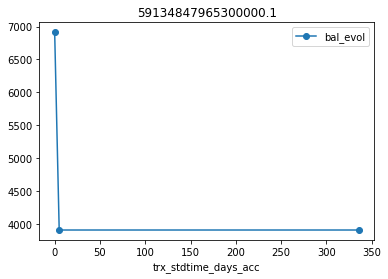

59134847965300000.1


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
18609,INFGRP,Borrowing from an informal Group,59134847965300000,59134847965300000.1,0,1. Starting balance (today),6912.0,6912.0,6912.0
392925,INFGRP,Borrowing from an informal Group,59134847965300000,59134847965300000.1,5,3. Payments,3000.0,3912.0,6912.0
18102,INFGRP,Borrowing from an informal Group,59134847965300000,59134847965300000.1,336,7. Closing Balance--End of last DQ,3912.0,3912.0,6912.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
18609,INFGRP,Borrowing from an informal Group,59134847965300000,59134847965300000.1,0,1. Starting balance (today),6912.0,6912.0,6912.0
392925,INFGRP,Borrowing from an informal Group,59134847965300000,59134847965300000.1,5,3. Payments,3000.0,3912.0,6912.0
18102,INFGRP,Borrowing from an informal Group,59134847965300000,59134847965300000.1,336,7. Closing Balance--End of last DQ,3912.0,3912.0,6912.0


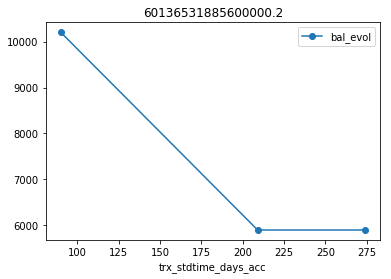

60136531885600000.2


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
6891,FRMLN,Individual Business or Agriculture Loan,60136531885600000,60136531885600000.2,90,1. Starting balance (today),4300.0,10200.0,10200.0
278423,FRMLN,Individual Business or Agriculture Loan,60136531885600000,60136531885600000.2,209,3. Payments,4300.0,5900.0,10200.0
4005,FRMLN,Individual Business or Agriculture Loan,60136531885600000,60136531885600000.2,274,6. Closing Balance--End of last DQ,0.0,5900.0,10200.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
249858,FRMLN,Individual Business or Agriculture Loan,60136531885600000,60136531885600000.1,0,2. New borrowing,7300.0,7300.0,7300.0
144080,FRMLN,Individual Business or Agriculture Loan,60136531885600000,60136531885600000.1,48,3. Payments,1400.0,5900.0,7300.0
6891,FRMLN,Individual Business or Agriculture Loan,60136531885600000,60136531885600000.2,90,1. Starting balance (today),4300.0,10200.0,10200.0
278423,FRMLN,Individual Business or Agriculture Loan,60136531885600000,60136531885600000.2,209,3. Payments,4300.0,5900.0,10200.0
4005,FRMLN,Individual Business or Agriculture Loan,60136531885600000,60136531885600000.2,274,6. Closing Balance--End of last DQ,0.0,5900.0,10200.0


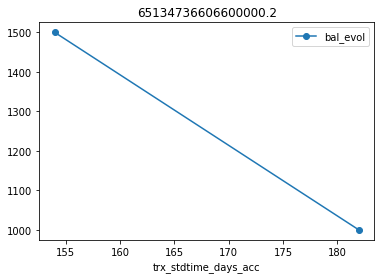

65134736606600000.2


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
51860,INFGRP,Borrowing from an informal Group,65134736606600000,65134736606600000.2,154,2. New borrowing,500.0,1500.0,1500.0
233553,INFGRP,Borrowing from an informal Group,65134736606600000,65134736606600000.2,182,3. Payments,500.0,1000.0,1500.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
9329,INFGRP,Borrowing from an informal Group,65134736606600000,65134736606600000.1,0,1. Starting balance (today),1000.0,1000.0,1000.0
51860,INFGRP,Borrowing from an informal Group,65134736606600000,65134736606600000.2,154,2. New borrowing,500.0,1500.0,1500.0
233553,INFGRP,Borrowing from an informal Group,65134736606600000,65134736606600000.2,182,3. Payments,500.0,1000.0,1500.0
168765,INFGRP,Borrowing from an informal Group,65134736606600000,65134736606600000.3,322,2. New borrowing,200.0,1200.0,1200.0
161039,INFGRP,Borrowing from an informal Group,65134736606600000,65134736606600000.4,336,2. New borrowing,200.0,1400.0,1400.0
327763,INFGRP,Borrowing from an informal Group,65134736606600000,65134736606600000.4,352,3. Payments,400.0,1000.0,1400.0
9153,INFGRP,Borrowing from an informal Group,65134736606600000,65134736606600000.4,366,7. Closing Balance--End of last DQ,1000.0,1000.0,1400.0


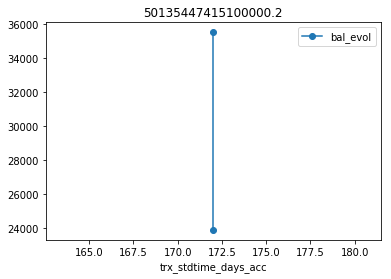

50135447415100000.2


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
242352,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.2,172,3. Payments,11610.0,23890.0,35500.0
315983,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.2,172,2. New borrowing,30000.0,35500.0,35500.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
14100,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.1,0,1. Starting balance (today),60000.0,60000.0,60000.0
1021,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.1,26,5. Interest accruing,1000.0,61000.0,60000.0
230528,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.1,46,3. Payments,11000.0,50000.0,60000.0
244683,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.1,74,3. Payments,11000.0,39000.0,60000.0
291474,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.1,109,3. Payments,11000.0,28000.0,60000.0
417805,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.1,137,3. Payments,11000.0,17000.0,60000.0
224298,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.1,144,3. Payments,11500.0,5500.0,60000.0
315983,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.2,172,2. New borrowing,30000.0,35500.0,35500.0
242352,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.2,172,3. Payments,11610.0,23890.0,35500.0
362567,INFGRP,Borrowing from an informal Group,50135447415100000,50135447415100000.3,200,2. New borrowing,30000.0,53890.0,53890.0


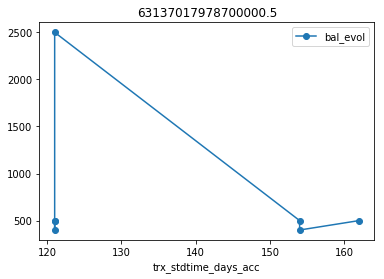

63137017978700000.5


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
21596,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.5,121,5. Interest accruing,100.0,500.0,2500.0
78333,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.5,121,3. Payments,2000.0,500.0,2500.0
336464,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.5,121,3. Payments,100.0,400.0,2500.0
407075,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.5,121,2. New borrowing,500.0,2500.0,2500.0
9094,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.5,154,5. Interest accruing,100.0,500.0,2500.0
123940,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.5,154,3. Payments,100.0,400.0,2500.0
8095,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.5,162,7. Closing Balance--End of last DQ,500.0,500.0,2500.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
408897,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.1,0,2. New borrowing,2000.0,2000.0,2000.0
241021,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.1,0,3. Payments,400.0,1600.0,2000.0
24378,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.1,0,5. Interest accruing,400.0,2000.0,2000.0
380381,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.2,30,3. Payments,2000.0,2000.0,4000.0
308607,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.2,30,3. Payments,400.0,1600.0,4000.0
180760,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.2,30,2. New borrowing,2000.0,4000.0,4000.0
16448,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.2,30,5. Interest accruing,400.0,2000.0,4000.0
120388,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.3,57,3. Payments,400.0,3600.0,4000.0
381012,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.3,57,3. Payments,2000.0,1600.0,4000.0
385429,INFGRP,Borrowing from an informal Group,63137017978700000,63137017978700000.3,57,2. New borrowing,2000.0,4000.0,4000.0


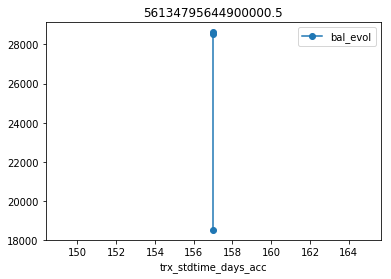

56134795644900000.5


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
16608,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.5,157,5. Interest accruing,100.0,28620.0,28520.0
159230,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.5,157,2. New borrowing,10000.0,28520.0,28520.0
228796,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.5,157,3. Payments,10100.0,18520.0,28520.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
20072,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.1,0,1. Starting balance (today),15000.0,15000.0,15000.0
308088,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.1,28,3. Payments,100.0,14900.0,15000.0
311021,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.2,31,2. New borrowing,20.0,14920.0,14920.0
281384,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.2,41,3. Payments,2500.0,12420.0,14920.0
338697,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.2,48,3. Payments,3000.0,9420.0,14920.0
195826,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.2,55,3. Payments,4000.0,5420.0,14920.0
172321,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.3,115,2. New borrowing,3000.0,8420.0,8420.0
16108,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.4,129,5. Interest accruing,100.0,18520.0,18420.0
350634,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.4,129,2. New borrowing,10000.0,18420.0,18420.0
16608,INFGRP,Borrowing from an informal Group,56134795644900000,56134795644900000.5,157,5. Interest accruing,100.0,28620.0,28520.0


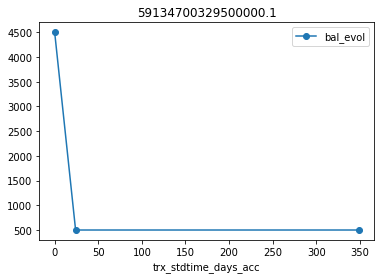

59134700329500000.1


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
5039,INFGRP,Borrowing from an informal Group,59134700329500000,59134700329500000.1,0,1. Starting balance (today),4500.0,4500.0,4500.0
62348,INFGRP,Borrowing from an informal Group,59134700329500000,59134700329500000.1,24,3. Payments,4000.0,500.0,4500.0
16203,INFGRP,Borrowing from an informal Group,59134700329500000,59134700329500000.1,349,7. Closing Balance--End of last DQ,500.0,500.0,4500.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
5039,INFGRP,Borrowing from an informal Group,59134700329500000,59134700329500000.1,0,1. Starting balance (today),4500.0,4500.0,4500.0
62348,INFGRP,Borrowing from an informal Group,59134700329500000,59134700329500000.1,24,3. Payments,4000.0,500.0,4500.0
16203,INFGRP,Borrowing from an informal Group,59134700329500000,59134700329500000.1,349,7. Closing Balance--End of last DQ,500.0,500.0,4500.0


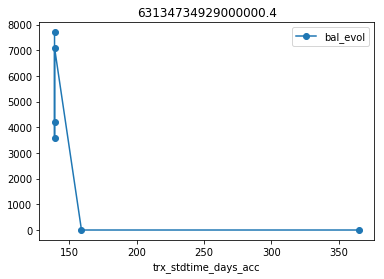

63134734929000000.4


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
23742,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.4,139,5. Interest accruing,600.0,7700.0,7100.0
39496,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.4,139,3. Payments,3500.0,4200.0,7100.0
229471,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.4,139,3. Payments,600.0,3600.0,7100.0
344700,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.4,139,2. New borrowing,3600.0,7100.0,7100.0
283388,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.4,159,3. Payments,3600.0,0.0,7100.0
5890,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.4,365,7. Closing Balance--End of last DQ,0.0,0.0,7100.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
9619,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.1,0,1. Starting balance (today),500.0,500.0,500.0
7542,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.2,8,5. Interest accruing,600.0,4600.0,4000.0
26750,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.2,8,3. Payments,600.0,4000.0,4000.0
302619,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.2,8,2. New borrowing,3500.0,4000.0,4000.0
360622,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.2,8,3. Payments,500.0,3500.0,4000.0
149184,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.3,76,2. New borrowing,3500.0,7000.0,7000.0
204976,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.3,76,3. Payments,3500.0,3500.0,7000.0
23742,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.4,139,5. Interest accruing,600.0,7700.0,7100.0
39496,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.4,139,3. Payments,3500.0,4200.0,7100.0
229471,INFGRP,Borrowing from an informal Group,63134734929000000,63134734929000000.4,139,3. Payments,600.0,3600.0,7100.0


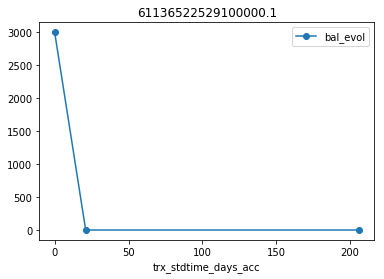

61136522529100000.1


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
184723,INFGRP,Borrowing from an informal Group,61136522529100000,61136522529100000.1,0,2. New borrowing,3000.0,3000.0,3000.0
471742,INFGRP,Borrowing from an informal Group,61136522529100000,61136522529100000.1,21,3. Payments,3000.0,0.0,3000.0
6074,INFGRP,Borrowing from an informal Group,61136522529100000,61136522529100000.1,206,7. Closing Balance--End of last DQ,0.0,0.0,3000.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
184723,INFGRP,Borrowing from an informal Group,61136522529100000,61136522529100000.1,0,2. New borrowing,3000.0,3000.0,3000.0
471742,INFGRP,Borrowing from an informal Group,61136522529100000,61136522529100000.1,21,3. Payments,3000.0,0.0,3000.0
6074,INFGRP,Borrowing from an informal Group,61136522529100000,61136522529100000.1,206,7. Closing Balance--End of last DQ,0.0,0.0,3000.0


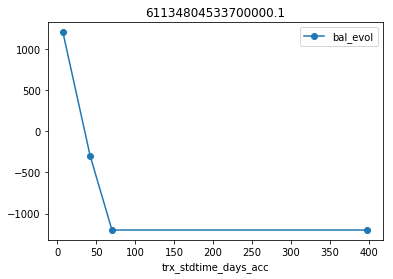

61134804533700000.1


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
5538,FRMLN,Joint liability loan,61134804533700000,61134804533700000.1,7,1. Starting balance (today),2400.0,1200.0,1200.0
335264,FRMLN,Joint liability loan,61134804533700000,61134804533700000.1,42,3. Payments,1500.0,-300.0,1200.0
125791,FRMLN,Joint liability loan,61134804533700000,61134804533700000.1,70,3. Payments,900.0,-1200.0,1200.0
5228,FRMLN,Joint liability loan,61134804533700000,61134804533700000.1,398,6. Closing Balance--End of last DQ,0.0,-1200.0,1200.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
61236,FRMLN,Joint liability loan,61134804533700000,61134804533700000.0,0,3. Payments,1200.0,-1200.0,-1200.0
5538,FRMLN,Joint liability loan,61134804533700000,61134804533700000.1,7,1. Starting balance (today),2400.0,1200.0,1200.0
335264,FRMLN,Joint liability loan,61134804533700000,61134804533700000.1,42,3. Payments,1500.0,-300.0,1200.0
125791,FRMLN,Joint liability loan,61134804533700000,61134804533700000.1,70,3. Payments,900.0,-1200.0,1200.0
5228,FRMLN,Joint liability loan,61134804533700000,61134804533700000.1,398,6. Closing Balance--End of last DQ,0.0,-1200.0,1200.0


In [24]:
for i in range(0,10):
    acc=random.choice(dfb["new_account_ids"].unique())
    dfb[dfb["new_account_ids"]==acc].sort_values("trx_stdtime_days_acc").plot(x="trx_stdtime_days_acc",y="bal_evol", title = acc,marker="o")
    plt.show()
    print(acc)
    display(dfb[dfb["new_account_ids"]==acc].sort_values("trx_stdtime_days_acc")[["trx_family_code","trx_type_desc","account_ids","new_account_ids","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","bal_evol","start_bal"]])
    display(dfb[dfb["account_ids"]==acc[:-2]].sort_values("trx_stdtime_days_acc")[["trx_family_code","trx_type_desc","account_ids","new_account_ids","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","bal_evol","start_bal"]])

## Seems ok, let's now save this dataset

In [25]:
dfb = dfb[dfb["start_bal"]>10]

In [28]:
dfb.to_csv("diaries_trx_trunc_loans_start_bal.csv")

### Careful: the column "unique_accnts" is not accurate anymore.

In [27]:
df.sample(5)

,hh_ids,unique_hhs,first_trx_date_hh,last_trx_date_hh,tot_hh_daysofobs,tot_hh_monthsofobs,interview_designation,int_date,int_month,int_year,int_yr_mo,first_int_date,account_ids,unique_accnts,m_ids_owner,unique_hm_owner,account_bsheet_desig,account_startclose_balance,account_formal,account_liquid,first_trx_date_acc,last_trx_date_acc,tot_acc_daysofobs,tot_acc_monthsofobs,trx_id,m_ids_trx,trx_date,trx_month,trx_year,trx_yr_mo,trx_dq_round,trx_stdtime_days_hh,trx_stdtime_mnths_hh,trx_stdtime_days_acc,trx_stdtime_mnths_acc,trx_class_code,trx_class_desc,trx_family_code,trx_family_desc,trx_type_code,trx_type_desc,trx_prx_purpose,trx_prx_purpose_fd,trx_fee,trx_bsheet_direction,trx_mode_code,trx_mode_desc,trx_place_incommunity,trx_distance_km,trx_outlet,trx_direction,trx_value_kes,trx_value_usd,ddd_gift,trx_inkind_units,trx_inkind_value_usd,trx_inkind_value_kes,trx_stdtime_mnths_hh_nr,bal_evol,start_bal
333421,KELDK20,NaN,30aug2012,02nov2013,429,14,04=Diaries Interview,16may2013,5,2013,2013_05,31aug2012,56134520264400000,NaN,65134442822400000,NaN,NaN,NaN,NaN,NaN,29sep2012,06sep2013,342,11,105136868521000000,65134442822400000,10may2013,5,2013,2013_05,9.0,253,8,223,7,income,Income (includes agricultural or business expe...,AGRI,Agriculture,3228,Agricultural Income,1. Agricultural Revenues (Sales),NaN,NaN,NaN,8.0,Purchase on credit/arrears,1.0,0.000000,NaN,Inflow,60.0,0.705882,0,NaN,NaN,NaN,8.724138,0.0,0.0
437229,KNBOM50,NaN,29aug2012,28oct2013,425,14,04=Diaries Interview,26oct2012,10,2012,2012_10,31aug2012,62134519924700000,NaN,62134380879000000,NaN,NaN,NaN,NaN,NaN,29sep2012,27oct2013,393,13,62135185188800000,62134380879000000,13oct2012,10,2012,2012_10,3.0,45,1,14,0,income,Income (includes agricultural or business expe...,CITMPC,Casual/temp employment,2825,"Casual employment, vibarua","1. Income, wages, tips, comissions",NaN,NaN,NaN,1.0,Cash,0.0,2.436038,NaN,Inflow,350.0,4.117647,0,NaN,NaN,NaN,1.551724,0.0,0.0
179058,KNBOK36,NaN,01nov2012,23oct2013,356,12,04=Diaries Interview,31jul2013,7,2013,2013_07,19dec2012,HH,NaN,HH,NaN,NaN,NaN,NaN,NaN,16aug2012,31dec2013,502,17,89137527116800000,79134985767500000,29jul2013,7,2013,2013_07,12.0,270,9,347,11,opex,Operational (Personal or household) expenditur...,FOOD,Food,2764,Groceries/food to be eaten at home (include ba...,Purchases,NaN,NaN,NaN,1.0,Cash,1.0,0.000000,"03=Duka or other small shop (butchery, chemist...",Outflow,100.0,1.176471,0,NaN,NaN,NaN,9.310345,0.0,0.0
313745,KVIHC31,NaN,03sep2012,25sep2013,387,13,04=Diaries Interview,18mar2013,3,2013,2013_03,27aug2012,HH,NaN,HH,NaN,NaN,NaN,NaN,NaN,16aug2012,31dec2013,502,17,59136362815000000,59134363516700000,08mar2013,3,2013,2013_03,7.0,186,6,204,7,opex,Operational (Personal or household) expenditur...,ENRGY,Energy,3030,"Gas (for cooking), paraffin, charcoal, etc.",Purchases,NaN,NaN,NaN,1.0,Cash,1.0,0.000000,"03=Duka or other small shop (butchery, chemist...",Outflow,10.0,0.117647,0,NaN,NaN,NaN,6.413793,0.0,0.0
88684,KNBOM15,NaN,01sep2012,30nov2013,455,15,04=Diaries Interview,19feb2013,2,2013,2013_02,24aug2012,HH,NaN,HH,NaN,NaN,NaN,NaN,NaN,16aug2012,31dec2013,502,17,62136126002700000,62134362978100000,15feb2013,2,2013,2013_02,11.0,167,5,183,6,opex,Operational (Personal or household) expenditur...,FOOD,Food,2765,"Food from restaurants, take aways, delivery, s...",Purchases,NaN,NaN,NaN,1.0,Cash,1.0,0.000000,"08=Restaurant, bar, hotel, cyber",Outflow,30.0,0.352941,0,NaN,NaN,NaN,5.758621,0.0,0.0
